In [1]:
# Basic NGSolve things
from netgen.geom2d import SplineGeometry
from ngsolve import *
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

# reference data from MFD
ref = np.loadtxt('data/mfd_hydrocoin_200.csv',comments='#',delimiter=',',skiprows=1)

In [2]:
# Hydrocoin mesh
from netgen.meshing import Element0D

geo = SplineGeometry()
pnts = [(0,150), (400,100), (800,150),(1200,100), (1600, 150), (1600, - 1000), 
       (1500, -1000), (1000, -1000), (0, -1000), (500+7500/13, -7500/13) ]

p1,p2,p3,p4,p5,p6,p7,p8,p9, p10 = [geo.AppendPoint(*pnt) for pnt in pnts]
geo.Append(["line",p1,p9], leftdomain=1, rightdomain=0, bc="left")
geo.Append(["line",p9,p8], leftdomain=1, rightdomain=0, bc="bottom")
geo.Append(["line",p8,p7], leftdomain=1, rightdomain=0, bc="bottom")
geo.Append(["line",p7,p6], leftdomain=1, rightdomain=0, bc="bottom")
geo.Append(["line",p6,p5], leftdomain=1, rightdomain=0, bc="right")
geo.Append(["line",p5,p4], leftdomain=1, rightdomain=0, bc="top")
geo.Append(["line",p4,p3], leftdomain=1, rightdomain=0, bc="top")
geo.Append(["line",p3,p2], leftdomain=1, rightdomain=0, bc="top")
geo.Append(["line",p2,p1], leftdomain=1, rightdomain=0, bc="top")
geo.Append(["line",p2,p10], leftdomain=1, rightdomain=1, bc="frac1")
geo.Append(["line",p4,p10], leftdomain=1, rightdomain=1, bc="frac2")
geo.Append(["line",p7,p10], leftdomain=1, rightdomain=1, bc="frac1")
geo.Append(["line",p8,p10], leftdomain=1, rightdomain=1, bc="frac2")

h0 = 60 # coarse mesh
mesh = Mesh(geo.GenerateMesh(maxh=h0))

# add BBND flags 
mesh.ngmesh.SetCD2Name(3,"i8") 
mesh.ngmesh.SetCD2Name(4,"i7") 
mesh.ngmesh.SetCD2Name(7,"i4") 
mesh.ngmesh.SetCD2Name(9,"i2") 
mesh.ngmesh.SetCD2Name(10,"i10") 


gfu = GridFunction(H1(mesh))
gfu.Set(1,definedon=mesh.BBoundaries("i2|i4|i7|i8|i10"))
Draw(gfu)

V = Compress(SurfaceL2(mesh, order=0, definedon=mesh.Boundaries("frac1|frac2")))
print("matrix elements: ", mesh.ne, "; fracture elements: ", V.ndof)

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

matrix elements:  1115 ; fracture elements:  44


## 1) CG: conforming

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

DOFS:  605


Text(0, 0.5, 'piezometric head [m]')

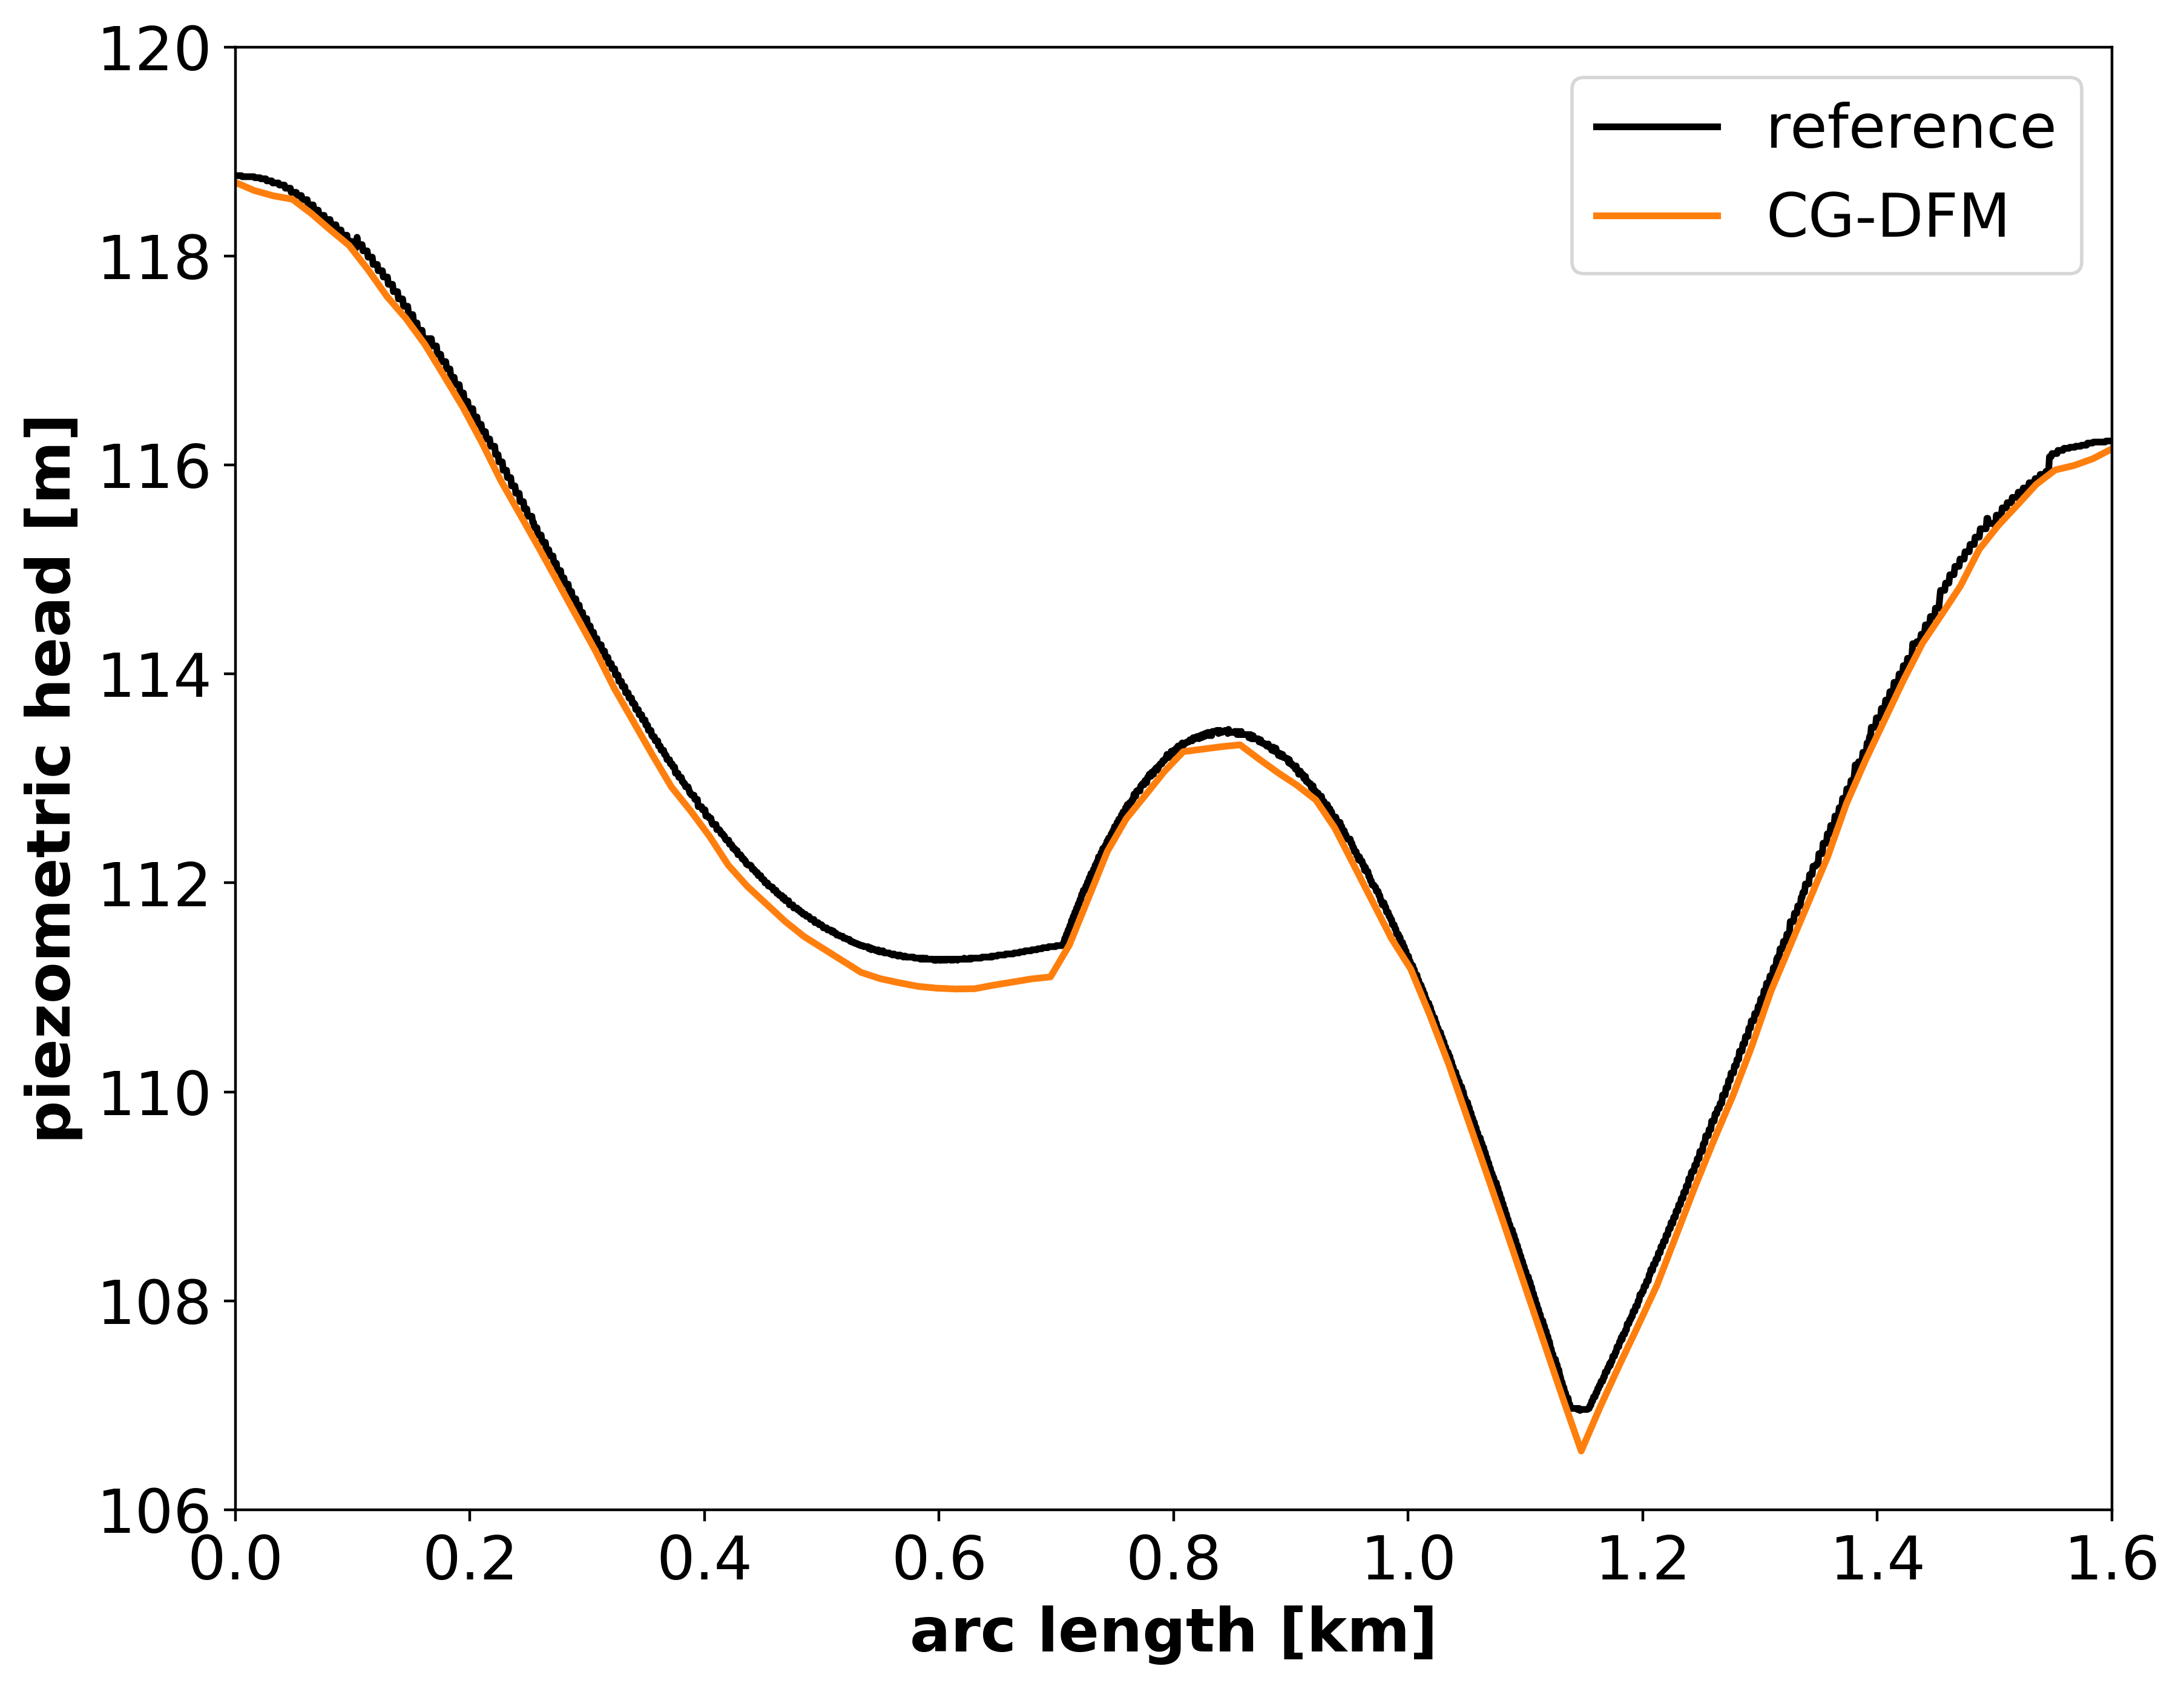

In [3]:
# CG solver: GOOD
fes = H1(mesh, dirichlet="top")
eps1, eps2 = 5*sqrt(2), 33/sqrt(5)
K0, K1 = 1e-8, 1e-6

u,v = fes.TnT()
a = BilinearForm(fes, symmetric=True)
a += K0*grad(u)*grad(v)*dx

# level set contribution (1)
a += eps1*K1 * grad(u).Trace() * grad(v).Trace()*ds("frac1")
a += eps2*K1 * grad(u).Trace() * grad(v).Trace()*ds("frac2")


f = LinearForm(fes)
gfu = GridFunction(fes)

a.Assemble()

# top dirichlet data
gfu.Set(y, definedon=mesh.Boundaries("top"))
f.vec.data -= a.mat*gfu.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs())*f.vec
Draw(gfu, mesh, "soln")

xx = np.linspace(0, 1600, 100)
pre = np.array([gfu(mesh(xx0,-200)) for xx0 in xx])

print("DOFS: ", fes.ndof)
plt.figure(figsize=(10,8), dpi=400)

plt.plot(ref.T[3]/1000, ref.T[0], "k", linewidth=2)
plt.plot(xx/1000, pre, 'C1', linewidth=2)
plt.legend(["reference", "CG-DFM"])
plt.axis([0,1.6, 106,120])
plt.xlabel("arc length [km]", fontweight='bold')
plt.ylabel("piezometric head [m]", fontweight='bold')


## 2) Hybrid-Mixed: conforming

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

Total:  6282  Global:  1822 V:  3345 W:  1115 M:  1691 Vf:  88 Mf:  43


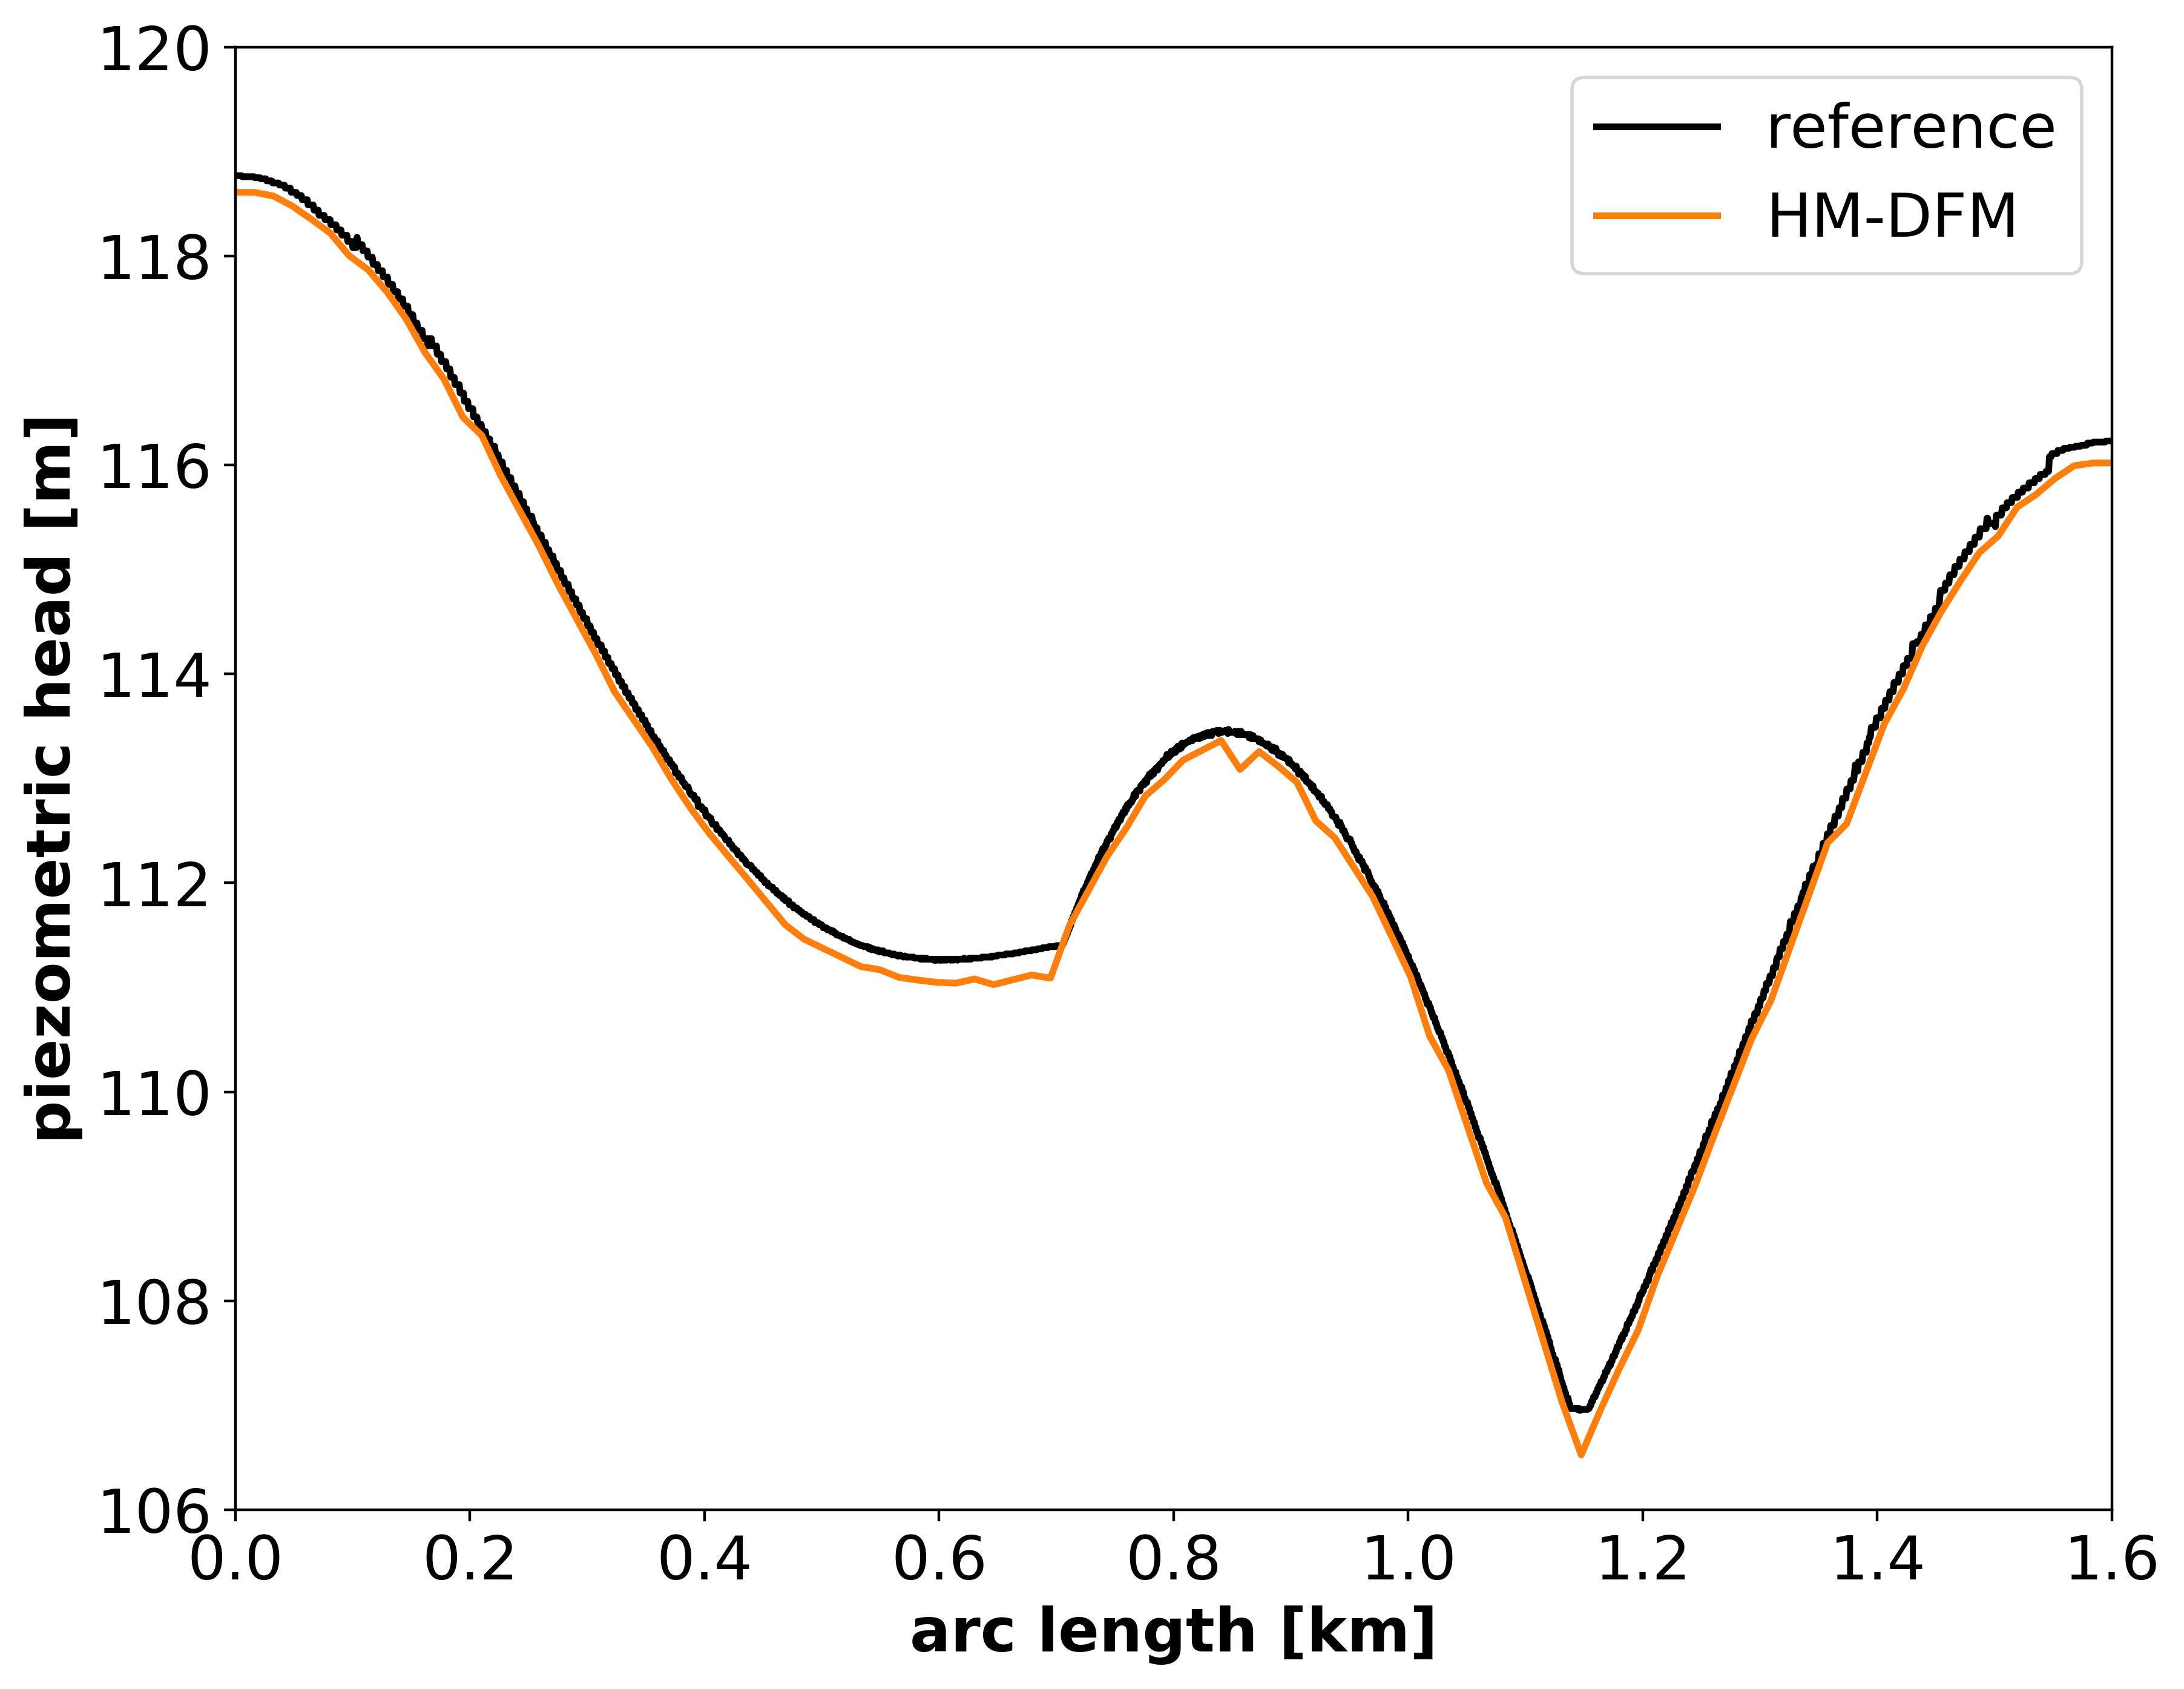

In [4]:
# hybrid-mixed solver: GOOD
order = 0
frac = "frac1|frac2"
V = HDiv(mesh, order=order, RT=True, discontinuous=True)
W = L2(mesh, order=order)
M = FacetFESpace(mesh, order=order, dirichlet="top")
Vf = Compress(SurfaceL2(mesh, order=order+1, definedon=mesh.Boundaries(frac)))
Mf = Compress(H1(mesh, order=1, definedon=mesh.Boundaries(frac), dirichlet_bbnd="i2|i4"))

fes = V*W*M*Vf*Mf
(u, p, phat, uf, pbar), (v, q, qhat, vf, qbar) = fes.TnT()

eps1, eps2 = 5*sqrt(2), 33/sqrt(5)
K0, K1 = 1e-8, 1e-6

alpha1 = 2*K1/eps1
alpha2 = 2*K1/eps2

condense=True
a = BilinearForm(fes, condense=condense)
h = specialcf.mesh_size
n = specialcf.normal(2)
t = specialcf.tangential(2)
# subdomain 1
a += (-1/K0*u*v+p*div(v)+q*div(u))*dx
a += (-1/eps1/K1*uf.Trace()*vf.Trace()+phat.Trace()*grad(vf).Trace()*t+qhat.Trace()*grad(uf).Trace()*t
     )*ds("frac1")
a += (-1/eps2/K1*uf.Trace()*vf.Trace()+phat.Trace()*grad(vf).Trace()*t+qhat.Trace()*grad(uf).Trace()*t
     )*ds("frac2")
a += (-v*n*phat-u*n*qhat)*dx(element_boundary=True)
# NOTE: gfn is a hacker for in-plane normal direction eta
gfn = GridFunction(Compress(SurfaceL2(mesh, order=1, definedon=mesh.Boundaries(frac))))
count = 0
for e in mesh.Elements(BND):
    if e.mat=="frac1" or e.mat=="frac2":
        if e.vertices[0].nr > e.vertices[1].nr:
            gfn.vec[2*count+1] = -1
        else:
            gfn.vec[2*count+1] = 1 
        count += 1    
a += -(pbar*vf*gfn+uf*qbar*gfn)*ds(element_boundary=True, definedon="frac1|frac2")


f = LinearForm(fes)

gfu = GridFunction(fes)

a.Assemble()
f.Assemble()

# top dirichlet data
gfu.components[2].Set(y, definedon=mesh.Boundaries("top"))
gfu.components[4].Set(y, definedon=mesh.BBoundaries("i2|i4"))

f.vec.data -= a.mat*gfu.vec
# NOTE: condensation is only performed in the matrix element level
if condense==True:
    f.vec.data += a.harmonic_extension_trans * f.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense), inverse="umfpack")*f.vec
if condense==True:
    gfu.vec.data += a.harmonic_extension * gfu.vec 
    gfu.vec.data += a.inner_solve * f.vec

# Local postprocessing
V2 = L2(mesh, order=1, all_dofs_together=False)
ph = GridFunction(V2)

a2 = BilinearForm(V2)
f2 = LinearForm(V2)

p2, q2 = V2.TnT()
a2 += grad(p2)*grad(q2)*dx
a2.Assemble()
f2 += -1/K0*gfu.components[0]*grad(q2)*dx
f2.Assemble()

V2.FreeDofs()[:mesh.ne]=False
ph.vec[:mesh.ne].data=gfu.components[1].vec[:mesh.ne]
ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec
    
Draw(ph, mesh, "soln")
# save data to vtk format for better visualization
vtkout = VTKOutput(ma=mesh, coefs=[ph], names=["pres"], filename="data/hydrocoin")
vtkout.Do()

xx = np.linspace(0, 1600, 100)
pre = np.array([ph(mesh(xx0,-200)) for xx0 in xx])

plt.figure(figsize=(10,8), dpi=400)

print("Total: ", sum(fes.FreeDofs()), " Global: ", sum(fes.FreeDofs(True)), 
     "V: ", sum(V.FreeDofs()), "W: ", sum(W.FreeDofs()), "M: ", sum(M.FreeDofs()), 
     "Vf: ", sum(Vf.FreeDofs(True)), "Mf: ", sum(Mf.FreeDofs(True)))
plt.plot(ref.T[3]/1000, ref.T[0], "k", linewidth=2)
plt.plot(xx/1000, pre, 'C1', linewidth=2)
plt.legend(["reference", "HM-DFM"])
plt.axis([0,1.6, 106,120])
plt.xlabel("arc length [km]", fontweight='bold')
plt.ylabel("piezometric head [m]", fontweight='bold')
plt.savefig("data/hydrocoin.pdf", dpi=400)